In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')


from tools import decode_switrs as ds

In [10]:
crashes_initial = pd.read_csv('data/Crashes.csv')
parties = pd.read_csv('data/Parties.csv')

In [11]:
crashes_initial.head()

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,COUNT_MC_KILLED,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y
0,7034739,2015,2015-08-22,3801,2015-02-26,1931,000985,RICHM,4,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.458750,37.779350
1,7035304,2014,2015-08-24,3801,2014-12-25,2245,A09861,INGLE,4,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.418788,37.710855
2,7202472,2016,2016-03-09,3801,2016-02-11,1100,1572,NaN,4,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.395850,37.781310
3,8042422,2016,2016-05-16,3801,2016-04-13,1050,001588,CENTR,3,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.399682,37.794241
4,8046723,2016,2016-05-18,3801,2016-04-16,1614,2472,MISIS,6,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.429839,37.761200


There are 80 columns describing a bike crash instance, with many containing code words that are interpreted here: https://tims.berkeley.edu/help/SWITRS.php#Codebook

In [75]:
crashes = ds.decode_switrs(crashes_initial, create_new_columns=True)

Created decoded column: WEATHER_1_DESC
Created decoded column: WEATHER_2_DESC
Created decoded column: COLLISION_SEVERITY_DESC
Created decoded column: TYPE_OF_COLLISION_DESC
Created decoded column: ROAD_SURFACE_DESC
Created decoded column: LIGHTING_DESC
Created decoded column: PCF_VIOL_CATEGORY_DESC
Created decoded column: MVIW_DESC


In [16]:
crashes.isna().sum().sort_values(ascending = False).head(30)

CITY_DIVISION_LAPD      5094
TRUCK_ACCIDENT          5049
CALTRANS_DISTRICT       5039
RAMP_INTERSECTION       5039
POSTMILE_PREFIX         5038
CALTRANS_COUNTY         5038
ROUTE_SUFFIX            5038
POSTMILE                5038
LOCATION_TYPE           5036
SIDE_OF_HWY             5008
STATE_ROUTE             5005
MOTORCYCLE_ACCIDENT     5001
LATITUDE                4977
LONGITUDE               4977
PEDESTRIAN_ACCIDENT     4855
ALCOHOL_INVOLVED        4786
DIRECTION               3050
PCF_VIOL_SUBSECTION     2901
PCF_VIOLATION            596
REPORTING_DISTRICT       373
BEAT_NUMBER              347
CHP_VEHTYPE_AT_FAULT     262
TOW_AWAY                 155
POINT_Y                  121
POINT_X                  121
OFFICER_ID                 2
STATE_HWY_IND              1
DISTANCE                   0
WEATHER_1                  0
INTERSECTION               0
dtype: int64

None of the missing data is pertinent to our analysis, so we will not drop any records for missing this inofrmation.

In [17]:
crashes['COLLISION_DATE_CLEAN'] = pd.to_datetime(crashes['COLLISION_DATE'], format = 'mixed', errors = 'coerce')

# EDA - Trend Analysis 

### Covid 19

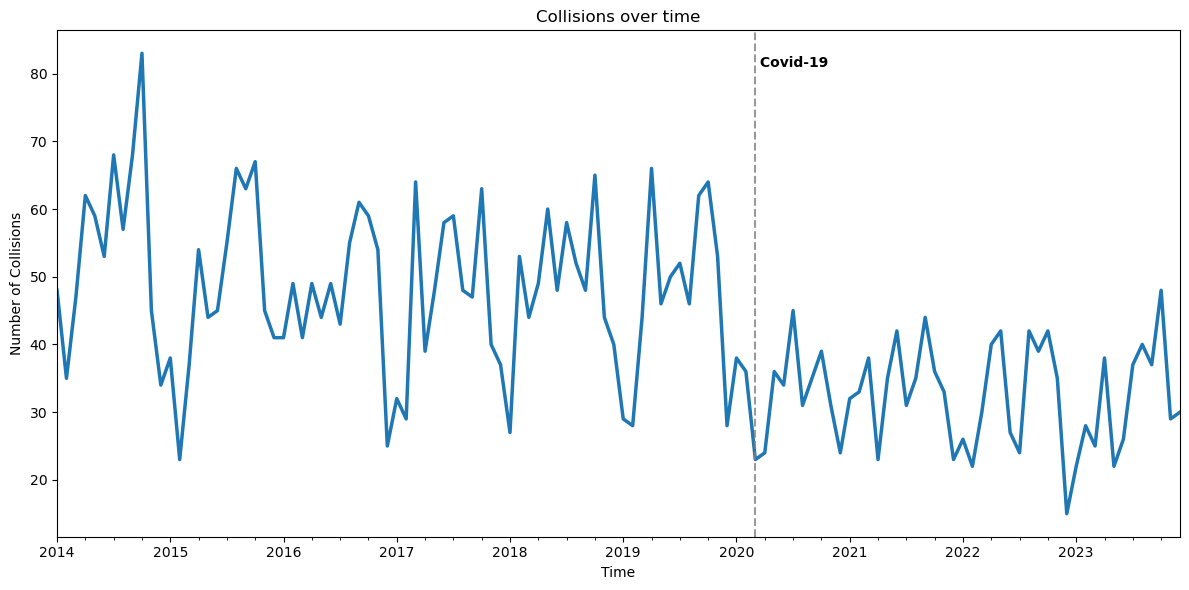

In [40]:
monthly_crashes = crashes.groupby(pd.Grouper(key = 'COLLISION_DATE_CLEAN', freq = 'ME')).size()
fig, ax = plt.subplots(figsize = (12,6))

monthly_crashes.plot(kind= 'line', ax = ax, linewidth = 2.5)


#covid line
ax.axvline(x=pd.Timestamp('2020-03-01'), color='grey', linestyle='--', linewidth=1.5, alpha=0.8)
ax.text(x=pd.Timestamp('2020-03-01'), y=0.95, s=' Covid-19', color='black', transform=ax.get_xaxis_transform(),
         ha='left', va='top', fontweight='bold')


ax.set_title('Collisions over time')
ax.set_xlabel('Time')
ax.set_ylabel('Number of Collisions')
plt.tight_layout()
plt.show()


We see that the number of crashes have not returned to Pre-covid numbers.

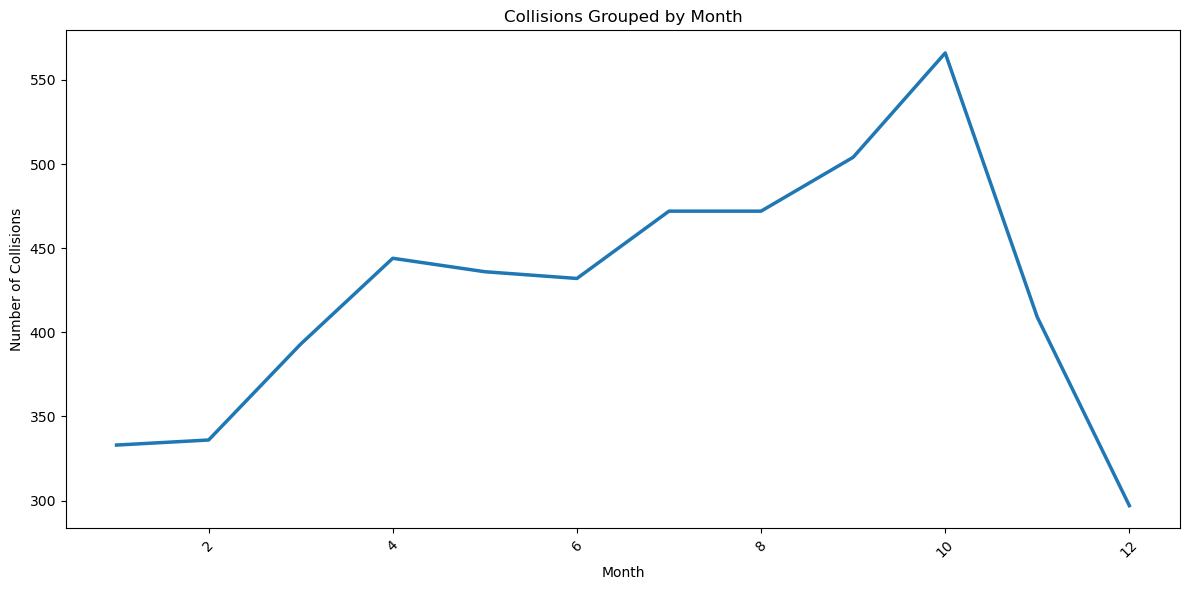

In [47]:

monthly_crashes = crashes.groupby(crashes['COLLISION_DATE_CLEAN'].dt.month).size()

fig, ax = plt.subplots(figsize = (12,6))

monthly_crashes.plot(kind= 'line', ax = ax, linewidth = 2.5)

ax.set_title('Collisions Grouped by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Collisions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Cumulatively, it seems that crashes peak around September/October, before falling sharply during winter periods

In [52]:
crashes['COLLISION_MONTH'] = crashes['COLLISION_DATE_CLEAN'].dt.month

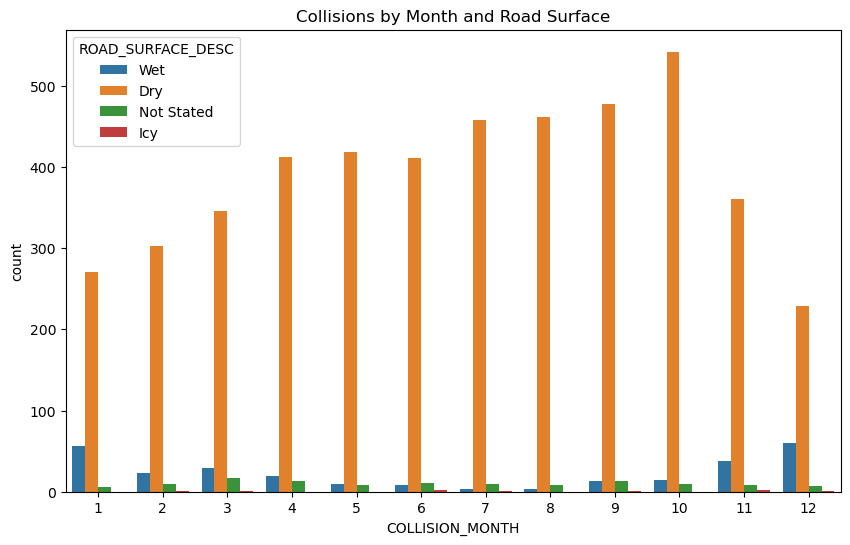

In [72]:
plt.figure(figsize=(10, 6))

sns.countplot(data=crashes, x='COLLISION_MONTH', hue='ROAD_SURFACE_DESC')
plt.title('Collisions by Month and Road Surface')
plt.show()

We thought maybe it was rainy season - guess not!

### Seasonal Variation

In [24]:
def get_season(date):
    month = date.month
    day = date.day
    if (month >= 3 and month <= 5):
        return 'Spring'
    elif (month >= 6 and month <= 8):
        return 'Summer'
    elif (month >= 9 and month <= 11):
        return 'Autumn'
    else:
        return 'Winter'

    
crashes['SEASON'] = crashes['COLLISION_DATE_CLEAN'].apply(get_season)

In [29]:
seasonly_crashes = crashes.groupby('SEASON').size()
seasonly_crashes

SEASON
Autumn    1479
Spring    1273
Summer    1376
Winter     966
dtype: int64

### Weekday vs Weekend

In [73]:
crashes.head()

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,WEATHER_1_DESC,WEATHER_2_DESC,COLLISION_SEVERITY_DESC,TYPE_OF_COLLISION_DESC,ROAD_SURFACE_DESC,LIGHTING_DESC,PCF_VIOL_CATEGORY_DESC,MVIW_DESC,COLLISION_DATE_CLEAN,COLLISION_MONTH
0,7034739,2015,2015-08-22,3801,2015-02-26,1931,000985,RICHM,4,5,...,Clear,Not Stated,Injury (Complaint of Pain),Sideswipe,Dry,Dark - Street Lights,08,Right Turn,2015-02-26,2
1,7035304,2014,2015-08-24,3801,2014-12-25,2245,A09861,INGLE,4,5,...,Clear,Not Stated,Injury (Complaint of Pain),Broadside,Dry,Dark - Street Lights,07,Right Turn,2014-12-25,12
2,7202472,2016,2016-03-09,3801,2016-02-11,1100,1572,NaN,4,5,...,Clear,Not Stated,Injury (Other Visible),Broadside,Dry,Daylight,07,Right Turn,2016-02-11,2
3,8042422,2016,2016-05-16,3801,2016-04-13,1050,001588,CENTR,3,5,...,Clear,Not Stated,Injury (Complaint of Pain),Other,Dry,Daylight,06,Right Turn,2016-04-13,4
4,8046723,2016,2016-05-18,3801,2016-04-16,1614,2472,MISIS,6,5,...,Clear,Not Stated,Injury (Other Visible),Sideswipe,Dry,Daylight,17,Right Turn,2016-04-16,4
